In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import fiona
from shapely.geometry import shape
import folium

# BusStopLocation_Jul2024 and TrainStation_Jul2024 directories
bus_stop_shp_path = "../datasets/geospatial_layer/BusStopLocation_Jul2024"
train_station_shp_path = "../datasets/geospatial_layer/TrainStation_Jul2024"

# Load Shapefiles into GeoDataFrames
gdf_bus_stops = gpd.read_file(bus_stop_shp_path)

# Open the shapefile with Fiona and read geometries and properties
with fiona.open(train_station_shp_path, 'r') as station_shape:
    # Creating a list to hold data
    data = []
    for feature in station_shape:
        # Safely get properties and geometry
        geom = shape(feature['geometry'])
        properties = feature['properties']
        data.append({**properties, 'geometry': geom})

# Create a GeoDataFrame from the extracted data
gdf_train_stations = gpd.GeoDataFrame(data, geometry='geometry')


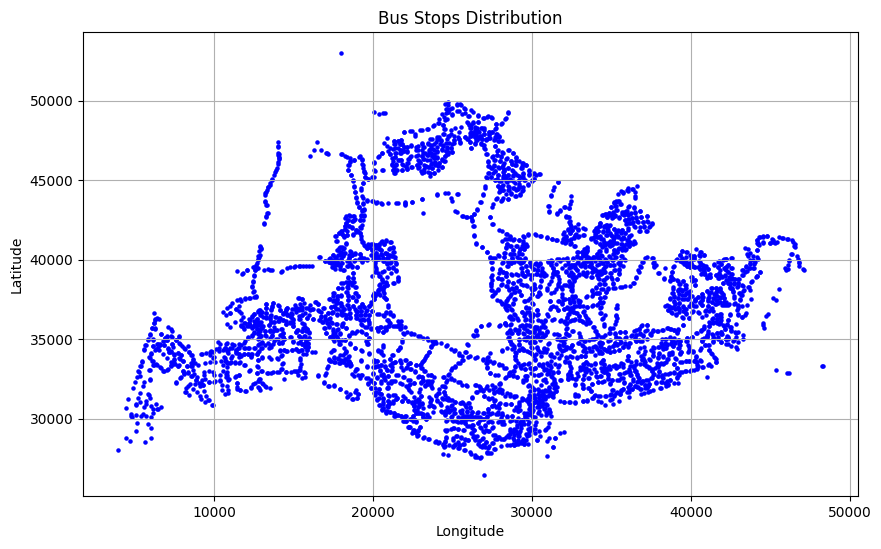

In [6]:
# Plot the bus stops to inspect their distribution
fig, ax = plt.subplots(figsize=(10, 10))
gdf_bus_stops.plot(ax=ax, marker='o', color='blue', markersize=5)
plt.title('Bus Stops Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [7]:
# Bus Stop Map

# Set up the map
map = folium.Map(location=[1.359394, 103.814301], zoom_start=12)

# Convert CRS to EPSG:4326 for mapping
gdf_bus_stops = gdf_bus_stops.to_crs(epsg=4326)  

# Add GeoJson layers for bus stops with customized tooltip
folium.GeoJson(
    gdf_bus_stops,
    name='Bus Stops',
    tooltip=folium.GeoJsonTooltip(fields=['LOC_DESC'], aliases=['']),  # Empty alias to remove 'LOC_DESC:'
    marker=folium.CircleMarker(radius=2, color="#3186cc", fill=True, fill_color="#3186cc")
).add_to(map)

# Add a layer control to toggle layers on and off
folium.LayerControl().add_to(map)

# Display the map inline if using Jupyter
map


In [8]:
# Train Station Map

if gdf_train_stations.crs is None:
    gdf_train_stations = gdf_train_stations.set_crs(epsg=3414)

# Project to a projected CRS for accurate centroid calculation
gdf_train_stations_proj = gdf_train_stations.to_crs(epsg=3414) 
gdf_train_stations_proj['geometry'] = gdf_train_stations_proj.geometry.centroid 

# Now project back to EPSG:4326 (geographic CRS for display)
gdf_train_stations = gdf_train_stations_proj.to_crs(epsg=4326)

# Initialize the map centered on Singapore
map = folium.Map(location=[1.3521, 103.8198], zoom_start=12, tiles='CartoDB positron')

# Add train stations as points to the map using CircleMarker
for idx, row in gdf_train_stations.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],  # centroid's coordinates
        radius=5, 
        color='red', 
        fill=True,
        fill_color='red',  
        fill_opacity=0.7,  
        tooltip=f"{row['STN_NAM_DE']}"  
    ).add_to(map)

# Add a layer control to toggle layers on and off
folium.LayerControl().add_to(map)

# Display the map
map  
